In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
import os, glob
import zipfile
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau

In [ ]:
base_folder = '/content/drive/MyDrive/cpdataset/maskUnet'
img_list = sorted(glob.glob(os.path.join(base_folder, '2d_images/*.tif')))
mask_list = sorted(glob.glob(os.path.join(base_folder, '2d_masks/*.tif')))
print("Number of image files:", len(img_list))
print("Number of mask files:", len(mask_list))

Number of image files: 267
Number of mask files: 267


In [ ]:
IMG_SIZE = 256
x_data, y_data = np.empty((2, len(img_list), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)

In [ ]:
for i, img_path in enumerate(img_list):
    img = imread(img_path)
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    x_data[i] = img

for i, img_path in enumerate(mask_list):
    img = imread(img_path)
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    y_data[i] = img


In [ ]:
x_data /= 255
y_data /= 255


x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2)
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 1))

In [ ]:

net = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
net = MaxPooling2D(pool_size=2, padding='same')(net)
net = Conv2D(64, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)
net = Conv2D(128, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)
net = Dense(128, activation='relu')(net)


net = UpSampling2D(size=2)(net)
net = Conv2D(128, kernel_size=3, activation='sigmoid', padding='same')(net)
net = UpSampling2D(size=2)(net)
net = Conv2D(64, kernel_size=3, activation='sigmoid', padding='same')(net)
net = UpSampling2D(size=2)(net)

outputs = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse'])
model.summary()
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, min_lr=1e-05)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856 

Epoch 1/25
7/7 [==============================] - 29s 2s/step - loss: 0.6127 - accuracy: 0.6650 - mse: 0.2009 - val_loss: 0.5468 - val_accuracy: 0.7457 - val_mse: 0.1784 - lr: 0.0010
Epoch 2/25
7/7 [==============================] - 1s 195ms/step - loss: 0.5512 - accuracy: 0.7404 - mse: 0.1805 - val_loss: 0.5361 - val_accuracy: 0.7458 - val_mse: 0.1755 - lr: 0.0010
Epoch 3/25
7/7 [==============================] - 1s 194ms/step - loss: 0.5274 - accuracy: 0.7444 - mse: 0.1719 - val_loss: 0.5074 - val_accuracy: 0.7448 - val_mse: 0.1632 - lr: 0.0010
Epoch 4/25
7/7 [==============================] - 1s 196ms/step - loss: 0.4895 - accuracy: 0.7442 - mse: 0.1571 - val_loss: 0.4493 - val_accuracy: 0.7457 - val_mse: 0.1404 - lr: 0.0010
Epoch 5/25
7/7 [==============================] - 1s 197ms/step - loss: 0.4138 - accuracy: 0.7532 - mse: 0.1281 - val_loss: 0.3483 - val_accuracy: 0.8407 - val_mse: 0.1045 - lr: 0.0010
Epoch 6/25
7/7 [==============================] - 1s 203ms/step - loss: 0.305

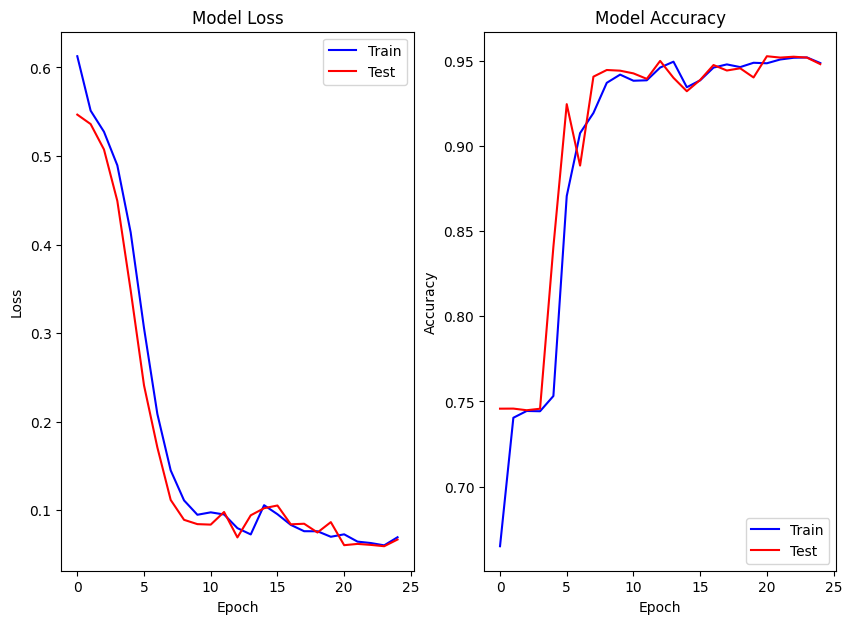

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs= 25, batch_size=32, callbacks=[reduce_lr])
fig, ax = plt.subplots(1, 2, figsize=(10, 7))


ax[0].set_title('Model Loss')
ax[0].plot(history.history['loss'], 'b')
ax[0].plot(history.history['val_loss'], 'r')
ax[0].legend(['Train', 'Test'], loc='upper right')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')


ax[1].set_title('Model Accuracy')
ax[1].plot(history.history['accuracy'], 'b')
ax[1].plot(history.history['val_accuracy'], 'r')
ax[1].legend(['Train', 'Test'], loc='lower right')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')

preds = model.predict(x_val)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


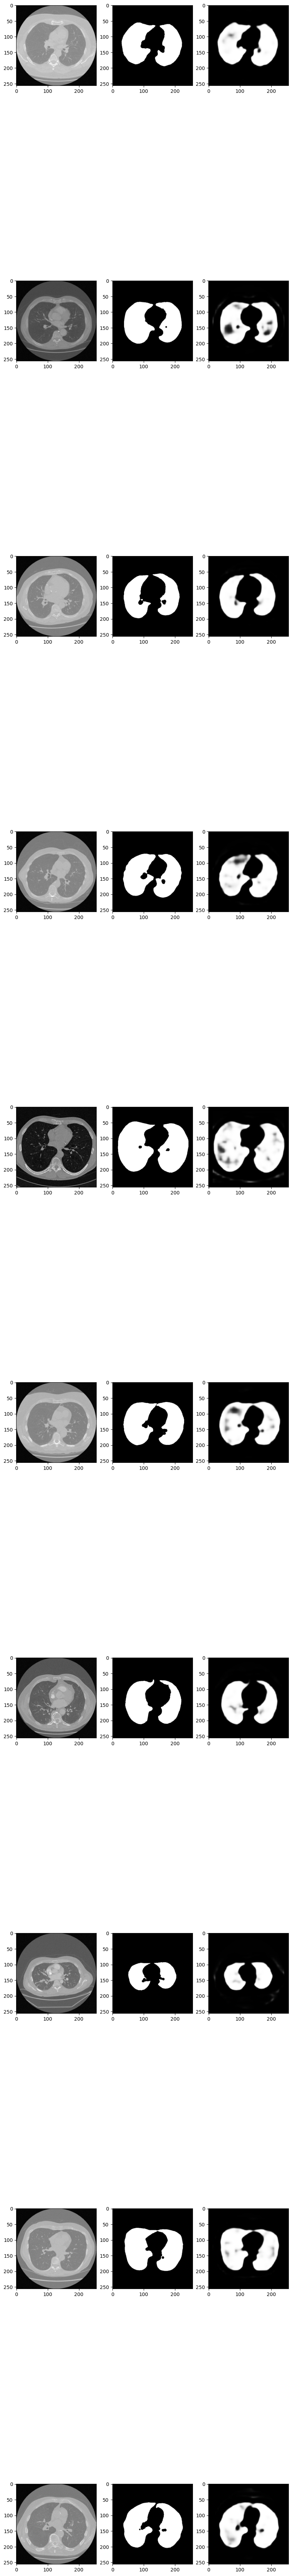

In [ ]:
fig, ax = plt.subplots(10, 3, figsize=(10, 100))
for i in range(10):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(preds[i].squeeze(), cmap='gray')


model.save('/content/drive/MyDrive/cpdataset/saved_model/unetModel.h5')

In [ ]:
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=len(test_generator)
)
print(f'Test accuracy: {test_accuracy}')

NameError: name 'test_generator' is not defined

In [ ]:
def print_lung_infection_details(mask, actual_mask):
    total_area = np.sum(mask > 0)  # Total lung area
    infected_area = np
    infected_area = np.sum((mask > 0) & (actual_mask > 0))  # Infected lung area
    healthy_area = total_area - infected_area  # Healthy lung area
    total_area_percentage = (total_area / mask.size) * 100
    infected_area_percentage = (infected_area / total_area) * 100
    healthy_area_percentage = (healthy_area / total_area) * 100

    print("Total lung area: {:.2f}%, Infected lung area: {:.2f}%, Healthy lung area: {:.2f}%".format(
        total_area_percentage, infected_area_percentage, healthy_area_percentage))

# Printing lung infection details for some samples
for i in range(10):
    print("Sample", i + 1)
    print_lung_infection_details(preds[i].squeeze(), y_val[i].squeeze())


Sample 1


NameError: name 'preds' is not defined

In [ ]:
print(vessel_area.dtype)

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/cpdataset/lung_infection_details.csv')

# Load UNet model
unet_model = load_model('/content/drive/MyDrive/cpdataset/saved_model/unetModel.h5')

# Function to calculate lung infection details
def calculate_lung_infection_details(mask, actual_mask):
    total_area = np.sum(mask > 0)  # Total lung area
    infected_area = np.sum((mask > 0) & (actual_mask > 0))  # Infected lung area
    healthy_area = total_area - infected_area  # Healthy lung area
    total_area_percentage = (total_area / mask.size) * 100
    infected_area_percentage = (infected_area / total_area) * 100
    healthy_area_percentage = (healthy_area / total_area) * 100
    return total_area_percentage, infected_area_percentage, healthy_area_percentage

# Load masks and save them to the corresponding folders
masks = []

In [ ]:
!pip install opencv-python==4.5.5.64

In [ ]:
for i in range(len(df)):
    mask_path = f'/content/drive/MyDrive/cpdataset/generated_masks/mask_{i+1}.png'  # Index starts from 1
    mask = imread(mask_path)
    masks.append(mask)
    # Create folder with the same name as the TIFF file
    folder_name = df.iloc[i]['Sample']
    os.makedirs(f'/content/drive/MyDrive/cpdataset/mask_images/{folder_name}', exist_ok=True)
    # Save mask in the folder
    imsave(f'/content/drive/MyDrive/cpdataset/mask_images/{folder_name}/mask.png', mask)

# Predict lung infection details for each mask
predicted_details = []


FileNotFoundError: No such file: '/content/drive/MyDrive/cpdataset/generated_masks/mask_1.png'

In [ ]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('/content/drive/MyDrive/cpdataset/lung_infection_details.csv')

# Display the contents
print(df)

    Sample  Total Lung Area (%)  Infected Lung Area (%)  Healthy Lung Area (%)
0        1                100.0               17.422485              82.577515
1        2                100.0               27.191162              72.808838
2        3                100.0               33.468628              66.531372
3        4                100.0               15.914917              84.085083
4        5                100.0                9.509277              90.490723
5        6                100.0               29.901123              70.098877
6        7                100.0               24.201965              75.798035
7        8                100.0               24.365234              75.634766
8        9                100.0               37.272644              62.727356
9       10                100.0               18.429565              81.570435
10      11                100.0               31.221008              68.778992
11      12                100.0               43.559